In [ ]:
import os
import requests, pathlib
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.agent_toolkits.sql.base import create_sql_agent
from langchain_groq import ChatGroq


# ==============================
# 1. Choose the LLM model (Llama 3)
# ==============================

# Another option? More parameters?
# Set Groq API key
os.environ["GROQ_API_KEY"] = "Enter API key here"

# Initialize Groq LLM
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.1,
    max_tokens=2048,
)

In [ ]:
# ==============================
# 2. Load Local Sample database
# ==============================

# Then we create a SQLite database. 
# SQLite is a lightweight database that is easy to set up. 
# We will be loading the sample database.

import pathlib
import pandas as pd
import sqlite3
from langchain_community.utilities import SQLDatabase

# Load local file
local_path = pathlib.Path(r"C:\Users\45235\Desktop\DATA 601\SampleData.xlsx")

if not local_path.exists():
    raise FileNotFoundError(f"Excel file not found: {local_path}")

print(f"Excel file found: {local_path}")

# Convert excel format to SQLite database
sqlite_path = local_path.with_suffix(".db")
conn = sqlite3.connect(sqlite_path)

# Read each sheet and write into SQLite
xls = pd.ExcelFile(local_path)
for sheet in xls.sheet_names:
    df = pd.read_excel(local_path, sheet_name=sheet)
    df.to_sql(sheet, conn, if_exists="replace", index=False)
    print(f"Imported sheet '{sheet}' into SQLite DB.")

conn.close()
print(f"SQLite database created: {sqlite_path}")

Excel file found: C:\Users\45235\Desktop\DATA 601\SampleData.xlsx
Imported sheet 'Sheet1' into SQLite DB.
SQLite database created: C:\Users\45235\Desktop\DATA 601\SampleData.db


In [7]:
# Check all available tables name
db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")


Dialect: sqlite
Available tables: ['Sheet1']


In [8]:
# Test sample and use pandas dataframe for better format
import pandas as pd
df = pd.read_sql_query("SELECT * FROM Sheet1 LIMIT 5;", sqlite3.connect(sqlite_path))
df

,ID,ActiveAccount,StudentID,DOB,Age,SchoolEmail,Age Group,AgeBands,PostCode,Gender,...,UnitSequence,CourseCountInATerm,UnitEnrolmentCount,EarliestUnitStartDate,locality,region,long,lat,territory,island
0,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,1,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
1,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,1,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
2,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,2,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
3,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,2,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
4,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,3,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island


In [10]:
# ==============================
# 3. Prepare SQL Toolkit
# ==============================


# Use the langchain_community package to interact with the database. 

'''When the LLM needs to know which tables are available in the database, it will call the sql_db_list_tables tool;
When the LLM needs to query the table schema (e.g., which columns a specific table has), it will call the sql_db_schema tool;
After the LLM generates an SQL statement, it will call the sql_db_query tool to execute it and retrieve the results;
It may even use the sql_db_query_checker tool to verify the validity of the SQL first, avoiding errors.'''

from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



The following ‘Validation Step’ are the key customization section, it allows us to customize each steps and making the model more controllable and reliable.
The workflow is as follow:


User question → Node 1 (list tables)
             → Node 2 (get schema)
             → Node 3 (generate SQL)
             → Node 4 (check SQL)
             → Node 5 (run SQL)

## **The following prompts are generated by AI, need customize with real world demands...**

Since the dataset only have 1 sheet called 'Sheet1', we force the model to query from 'sheet1'

In [ ]:
# ==============================
# 0. Imports
# ==============================
from typing import Literal
from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

# ==============================
# 1. Load Tools
# ==============================
raw_schema_tool = next(t for t in tools if t.name == "sql_db_schema")
run_query_tool = next(t for t in tools if t.name == "sql_db_query")
list_tables_tool = next(t for t in tools if t.name == "sql_db_list_tables")
get_table_rows_tool = next((t for t in tools if t.name == "get_table_rows"), None)

# ==============================
# 2. Safe schema tool wrapper
# ==============================
@tool
def sql_db_schema_safe(_args: dict = None):
    """Return the database schema. This tool takes no arguments."""
    return raw_schema_tool.invoke({})

get_schema_tool = sql_db_schema_safe

# ==============================
# 3. Helper functions / nodes
# ==============================
def list_tables(state: MessagesState):
    """List all tables in the database."""
    tool_message = list_tables_tool.invoke({})
    response = AIMessage(f"Available tables: {getattr(tool_message, 'content', str(tool_message))}")
    return {"messages": [response]}

def call_get_schema(state: MessagesState):
    """Call safe schema tool and show core fields only."""
    all_tools = [get_schema_tool, run_query_tool, list_tables_tool]
    if get_table_rows_tool:
        all_tools.append(get_table_rows_tool)
    llm_with_tools = llm.bind_tools(all_tools)

    schema_response = llm_with_tools.invoke(state["messages"])

    # Core fields in education database
    core_fields = [
        "StudentID", "Age", "Age Group", "Gender", "CitizenCoutry", "VisaType",
        "ProgrammeEnrolmentID", "ProgrammeCode", "NZQFLevel", "EnrolmentStatus",
        "UnitEnrolmentID", "UnitOfferCode", "UnitResult", "NZQAOutcome", "UnitStartDate",
        "locality", "region"
    ]

    filtered_schema_content = f"Education Database Core Fields (Total {len(core_fields)}):\n"
    filtered_schema_content += ", ".join(core_fields)
    filtered_schema_content += "\n\nRelationships:\n- Student ↔ Programme: StudentID\n- Programme ↔ Course: ProgrammeEnrolmentID\n- Student ↔ Grades: StudentID → ProgrammeEnrolmentID → UnitEnrolmentID"

    filtered_response = AIMessage(
        content=filtered_schema_content,
        tool_calls=getattr(schema_response, "tool_calls", None)
    )
    return {"messages": [filtered_response]}

# ==============================
# 4. Generate SQL query node
# ==============================

generate_query_system_prompt = f"""
You are an agent for an EDUCATION STUDENT MANAGEMENT database.
You must use only the table 'Sheet1'.
Allowed columns (must use exactly these, no others): 
StudentID, Age, Age Group, Gender, CitizenCoutry, VisaType, ProgrammeEnrolmentID, ProgrammeCode, NZQFLevel, EnrolmentStatus, 
UnitEnrolmentID, UnitOfferCode, UnitResult, NZQAOutcome, UnitStartDate, locality, region

Rules:
1. Only use columns from Sheet1. Do NOT use any other table.
2. Do NOT join Sheet1 with any other table.
3. Do NOT use SELECT * or any DML statements (INSERT, UPDATE, DELETE, DROP).
4. Always return at most 5 rows unless the user explicitly requests more.
5. Always reference columns exactly as listed; do NOT rename or guess column names.
6. If filtering by a value, use WHERE clauses referencing columns from Sheet1 only.

!! HARD RULE !!
If the question uses ANY table name other than Sheet1,
you MUST rewrite it internally to Sheet1.

If the question uses ANY column name not in the allowed list,
replace it with the closest correct column name OR ask for clarification.

NEVER output a query containing an unknown table or unknown column.

"""

def generate_query(state: MessagesState):
    """Generate SQL query using only Sheet1 with universal fallback."""
    system_message = {"role": "system", "content": generate_query_system_prompt}
    llm_with_tools = llm.bind_tools([run_query_tool, get_schema_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    # ----------------------
    # Universal Fallback Logic
    # ----------------------
    query_calls = []
    for c in (response.tool_calls or []):
        if c["name"] == "sql_db_query":
            query_calls.append(c)

    # If no SQL DB calls detected → insert fallback
    if not query_calls:
        universal_fallback_query = """
            SELECT 
                StudentID,
                Age,
                Gender,
                CitizenCoutry,
                ProgrammeCode,
                EnrolmentStatus,
                locality,
                region
            FROM Sheet1
            LIMIT 5;
        """

        query_calls.append({
            "name": "sql_db_query",
            "args": {"query": universal_fallback_query},
            "id": "auto_universal_fallback_1",
            "type": "tool_call"
        })

    response.tool_calls = query_calls
    return {"messages": [response]}


# ==============================
# 5. Validate SQL query
# ==============================

check_query_system_prompt = """
You are a SQL expert in EDUCATION databases.
Check for syntax or schema errors.
Return only the corrected SQL query if needed, otherwise return the original query.
"""

def check_query(state: MessagesState):
    """Validate generated SQL query, do NOT replace table names."""
    last_msg = state["messages"][-1]
    if not hasattr(last_msg, "tool_calls") or len(last_msg.tool_calls) == 0:
        return {"messages": [AIMessage("Error: No query tool call found")]}

    tool_call = last_msg.tool_calls[0]
    query_to_validate = tool_call.get("args", {}).get("query", "")
    if not query_to_validate:
        return {"messages": [AIMessage("Error: Query missing in tool call")]}

    system_message = {"role": "system", "content": check_query_system_prompt}
    user_message = {"role": "user", "content": query_to_validate}

    all_tools = [get_schema_tool, run_query_tool, list_tables_tool]
    if get_table_rows_tool:
        all_tools.append(get_table_rows_tool)
    llm_with_tools = llm.bind_tools(all_tools)

    validation_response = llm_with_tools.invoke([system_message, user_message])

    # Keep table name as Sheet1
    if getattr(validation_response, "tool_calls", None):
        validated_query = validation_response.tool_calls[0]["args"]["query"]
        updated_tool_calls = [{**tool_call, "args": {"query": validated_query}}]
        validated_msg = AIMessage(content=validation_response.content, tool_calls=updated_tool_calls, id=last_msg.id)
    else:
        validated_msg = AIMessage(content=validation_response.content, tool_calls=[tool_call], id=last_msg.id)

    return {"messages": [validated_msg]}

# ==============================
# 6. Optional: Format date
# ==============================

def format_date_query(state: MessagesState):
    """Optional: Convert dates to dialect-specific format."""
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        query = last_msg.tool_calls[0]["args"]["query"]
        if db.dialect == "mysql":
            query = query.replace("'2025-01-01'", "STR_TO_DATE('2025-01-01','%Y-%m-%d')")
        elif db.dialect == "postgresql":
            query = query.replace("'2025-01-01'", "TO_DATE('2025-01-01','YYYY-MM-DD')")
        updated_tool_calls = [{**call, "args": {"query": query}} for call in last_msg.tool_calls]
        state["messages"][-1].tool_calls = updated_tool_calls
    return {"messages": state["messages"]}

# ==============================
# 7. Build workflow (Need more modifications...)
# ==============================
workflow = StateGraph(MessagesState)

workflow.add_node("list_tables", list_tables)
workflow.add_node("get_schema", call_get_schema)
workflow.add_node("generate_query", generate_query)
workflow.add_node("check_query", check_query)
workflow.add_node("format_date_query", format_date_query)
workflow.add_node("run_query", ToolNode([run_query_tool], name="run_query"))

workflow.add_edge(START, "list_tables")
workflow.add_edge("list_tables", "get_schema")
workflow.add_edge("get_schema", "generate_query")
workflow.add_edge("generate_query", "check_query")
workflow.add_edge("check_query", "run_query")
workflow.add_edge("run_query", END)

agent = workflow.compile()

## **Need full, realistic workflow including optional paths and fallbacks.**

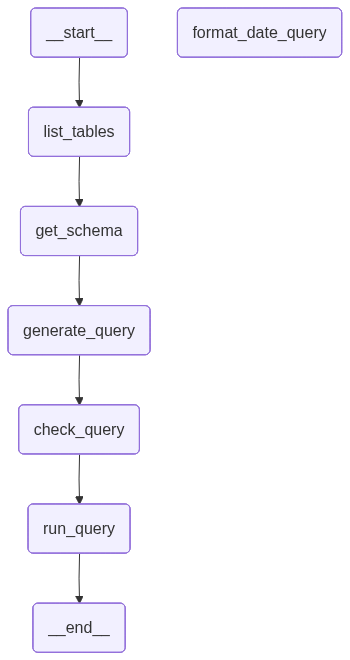

In [17]:
# ==============================
# 8. Display workflow graph
# ==============================
from IPython.display import Image, display

# Draw the workflow graph as PNG and display inline
png_bytes = agent.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [18]:
# ==============================
# 8. Run a sample question 1
# ==============================
question = "Which Student has lowest age?"

for step in agent.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which Student has lowest age?
================================== Ai Message ==================================

Available tables: Sheet1
================================== Ai Message ==================================

Education Database Core Fields (Total 17):
StudentID, Age, Age Group, Gender, CitizenCoutry, VisaType, ProgrammeEnrolmentID, ProgrammeCode, NZQFLevel, EnrolmentStatus, UnitEnrolmentID, UnitOfferCode, UnitResult, NZQAOutcome, UnitStartDate, locality, region

Relationships:
- Student ↔ Programme: StudentID
- Programme ↔ Course: ProgrammeEnrolmentID
- Student ↔ Grades: StudentID → ProgrammeEnrolmentID → UnitEnrolmentID
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (3zm45mvvv)
 Call ID: 3zm45mvvv
  Args:
    query: SELECT StudentID FROM Sheet1 ORDER BY Age ASC LIMIT 1
================================== Ai Message ====================

In [30]:
# ==============================
# 8. Run a sample question 2
# ==============================

# 1. Generate the thinking process and query result
question = "How many students are under 50 years old"

# store last tool query result
last_sql_result = None

for step in agent.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="values"):
    step["messages"][-1].pretty_print()

    # Capture sql_db_query result
    if step["messages"][-1].type == "tool":
        last_sql_result = step["messages"][-1].content

# 2. Generate results into a dataframe
import ast
import pandas as pd

def normalize_sql_result(raw):
    """
    Convert raw SQL result into a clean 2D list for DataFrame.
    Handles:
      - list of tuples
      - tuple
      - single values
      - stringified list: "[(1,)]"
      - None
    """

    if raw is None:
        return []

    # If result is a string like "[(5258,)]", convert using ast.literal_eval
    if isinstance(raw, str):
        try:
            raw = ast.literal_eval(raw)
        except:
            return []

    # If result is a single tuple (e.g., (5258,))
    if isinstance(raw, tuple):
        return [list(raw)]

    # If result is a single value: 5258
    if not isinstance(raw, (list, tuple)):
        return [[raw]]

    # If result is list of tuples
    if isinstance(raw, list):
        new_rows = []
        for row in raw:
            if isinstance(row, (list, tuple)):
                new_rows.append(list(row))
            else:
                new_rows.append([row])
        return new_rows

    return []


# ------------------------------
# Use this instead of DataFrame(result)
# ------------------------------

clean_rows = normalize_sql_result(result)
df = pd.DataFrame(clean_rows)

# If the query returns COUNT(*), name the column properly
if df.shape[1] == 1:
    df.columns = ["result"]

display(df)


================================ Human Message =================================

How many students are under 50 years old
================================== Ai Message ==================================

Available tables: Sheet1
================================== Ai Message ==================================

Education Database Core Fields (Total 17):
StudentID, Age, Age Group, Gender, CitizenCoutry, VisaType, ProgrammeEnrolmentID, ProgrammeCode, NZQFLevel, EnrolmentStatus, UnitEnrolmentID, UnitOfferCode, UnitResult, NZQAOutcome, UnitStartDate, locality, region

Relationships:
- Student ↔ Programme: StudentID
- Programme ↔ Course: ProgrammeEnrolmentID
- Student ↔ Grades: StudentID → ProgrammeEnrolmentID → UnitEnrolmentID
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (rvhv7a4tc)
 Call ID: rvhv7a4tc
  Args:
    query: SELECT COUNT(*) FROM Sheet1 WHERE Age < 50
================================== Ai Message ====================

,result
0,5258


In [31]:
# ==============================
# 8. Run a sample question 3 (More complicated with 2 more conditions)
# ==============================

question = "How many male students are located in Mt Albert"

# store last tool query result
last_sql_result = None

# Run agent stream and capture SQL result
for step in agent.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="values"):
    step["messages"][-1].pretty_print()

    # Capture sql_db_query result (tool output)
    if step["messages"][-1].type == "tool":
        last_sql_result = step["messages"][-1].content


# ==============================
# Convert SQL result into DataFrame
# ==============================

import ast
import pandas as pd

def normalize_sql_result(raw):
    if raw is None:
        return []

    if isinstance(raw, str):
        try:
            raw = ast.literal_eval(raw)
        except:
            return []

    if isinstance(raw, tuple):
        return [list(raw)]

    if not isinstance(raw, (list, tuple)):
        return [[raw]]

    if isinstance(raw, list):
        new_rows = []
        for row in raw:
            if isinstance(row, (tuple, list)):
                new_rows.append(list(row))
            else:
                new_rows.append([row])
        return new_rows

    return []


clean_rows = normalize_sql_result(last_sql_result)
df = pd.DataFrame(clean_rows)

# Automatically rename column if COUNT(*)
if df.shape[1] == 1:
    df.columns = ["result"]

display(df)

================================ Human Message =================================

How many male students are located in Mt Albert
================================== Ai Message ==================================

Available tables: Sheet1
================================== Ai Message ==================================

Education Database Core Fields (Total 17):
StudentID, Age, Age Group, Gender, CitizenCoutry, VisaType, ProgrammeEnrolmentID, ProgrammeCode, NZQFLevel, EnrolmentStatus, UnitEnrolmentID, UnitOfferCode, UnitResult, NZQAOutcome, UnitStartDate, locality, region

Relationships:
- Student ↔ Programme: StudentID
- Programme ↔ Course: ProgrammeEnrolmentID
- Student ↔ Grades: StudentID → ProgrammeEnrolmentID → UnitEnrolmentID
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (3rs5j7jjt)
 Call ID: 3rs5j7jjt
  Args:
    query: SELECT COUNT(*) FROM Sheet1 WHERE locality = 'Mt Albert' AND Gender = 'Male'
=========================

,result
0,57


In [32]:
# ==============================
# 8. Run a sample question 4 (List the results in tables)
# ==============================

question = "List male students who are located in Mt Albert"

# store last tool query result
last_sql_result = None

# Run agent stream and capture SQL result
for step in agent.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="values"):
    step["messages"][-1].pretty_print()

    # Capture sql_db_query result (tool output)
    if step["messages"][-1].type == "tool":
        last_sql_result = step["messages"][-1].content


# ==============================
# Convert SQL result into DataFrame
# ==============================

import ast
import pandas as pd

def normalize_sql_result(raw):
    if raw is None:
        return []

    if isinstance(raw, str):
        try:
            raw = ast.literal_eval(raw)
        except:
            return []

    if isinstance(raw, tuple):
        return [list(raw)]

    if not isinstance(raw, (list, tuple)):
        return [[raw]]

    if isinstance(raw, list):
        new_rows = []
        for row in raw:
            if isinstance(row, (tuple, list)):
                new_rows.append(list(row))
            else:
                new_rows.append([row])
        return new_rows

    return []


clean_rows = normalize_sql_result(last_sql_result)
df = pd.DataFrame(clean_rows)

# Automatically rename column if COUNT(*)
if df.shape[1] == 1:
    df.columns = ["result"]

display(df)

================================ Human Message =================================

List male students who are located in Mt Albert
================================== Ai Message ==================================

Available tables: Sheet1
================================== Ai Message ==================================

Education Database Core Fields (Total 17):
StudentID, Age, Age Group, Gender, CitizenCoutry, VisaType, ProgrammeEnrolmentID, ProgrammeCode, NZQFLevel, EnrolmentStatus, UnitEnrolmentID, UnitOfferCode, UnitResult, NZQAOutcome, UnitStartDate, locality, region

Relationships:
- Student ↔ Programme: StudentID
- Programme ↔ Course: ProgrammeEnrolmentID
- Student ↔ Grades: StudentID → ProgrammeEnrolmentID → UnitEnrolmentID
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (cxamkdv88)
 Call ID: cxamkdv88
  Args:
    query: SELECT * FROM Sheet1 WHERE Gender = 'Male' AND locality = 'Mt Albert'
================================

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,1,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
1,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,1,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
2,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,2,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
3,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,2,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
4,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,3,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
5,162,0,AEU0000160,23991.0,59.0,aeu0000160@aspire2student.ac.nz,25 and Over,56–60,1025,Male,...,3,2,6,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
6,1269,0,AEU3000815,29238.0,44.0,aeu3000815@aspire2student.ac.nz,25 and Over,41–45,1025,Male,...,1,1,4,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
7,1269,0,AEU3000815,29238.0,44.0,aeu3000815@aspire2student.ac.nz,25 and Over,41–45,1025,Male,...,2,1,4,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
8,1269,0,AEU3000815,29238.0,44.0,aeu3000815@aspire2student.ac.nz,25 and Over,41–45,1025,Male,...,3,1,4,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island
9,1269,0,AEU3000815,29238.0,44.0,aeu3000815@aspire2student.ac.nz,25 and Over,41–45,1025,Male,...,4,1,4,None,Mt Albert,Auckland,174.7238,-36.8844,Auckland,North Island


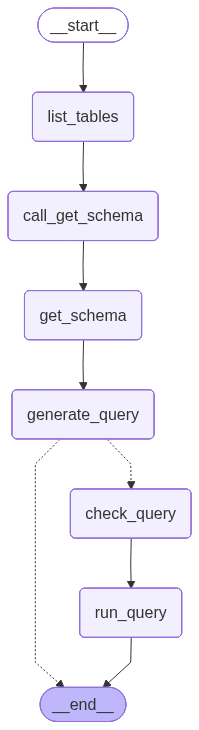

In [ ]:
# Need define workflow like this?
# # Visualize the application below:

# from IPython.display import Image, display
# from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# display(Image(agent.get_graph().draw_mermaid_png()))